# PDB to similarity pipeline (CA-only)

This notebook builds a CA-only distance pipeline from PDB files in `data/`,
pads or trims to a fixed length, filters invalid samples, converts to
similarity matrices, and prepares a PyTorch Dataset + DataLoader split.


In [2]:
from __future__ import annotations

from pathlib import Path
import csv
import random
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

try:
    import torch
    from torch.utils.data import Dataset, DataLoader, Subset
except ImportError as exc:
    raise ImportError(
        "This notebook requires torch. Install it before running the pipeline."
    ) from exc

DATA_DIR = Path("data")
PDB_GLOB = "*.pdb"

TARGET_L = 100
CHAIN_STRATEGY = "longest"  # "longest" | "single" | "concat"
SIGMA = 10.0
PAD_VALUE = np.inf
MIN_RESIDUES = 2
RANDOM_SEED = 42

MAX_FILES = None  # set an int for a quick smoke run

OUTPUT_DIR = Path("data") / f"precomputed_L{TARGET_L}"
MANIFEST_PATH = OUTPUT_DIR / "manifest.csv"


In [3]:
pdb_files = sorted(DATA_DIR.glob(PDB_GLOB))
if MAX_FILES:
    pdb_files = pdb_files[:MAX_FILES]
print(f"Found {len(pdb_files)} PDB files")
pdb_files[:5]


Found 6631 PDB files


[PosixPath('data/16pkA01.pdb'),
 PosixPath('data/16vpA00.pdb'),
 PosixPath('data/1a0rP02.pdb'),
 PosixPath('data/1a1xA00.pdb'),
 PosixPath('data/1a3qA01.pdb')]

In [4]:
def parse_ca_coords(pdb_path: Path, chain_strategy: str = "longest"):
    chains = {}
    chain_order = []
    with pdb_path.open("r") as handle:
        for line in handle:
            if not line.startswith("ATOM"):
                continue
            if line[12:16].strip() != "CA":
                continue
            altloc = line[16]
            if altloc not in (" ", "A"):
                continue
            chain_id = line[21].strip() or "_"
            try:
                resseq = int(line[22:26].strip())
            except ValueError:
                continue
            icode = line[26].strip() or " "
            res_uid = (resseq, icode)
            if chain_id not in chains:
                chains[chain_id] = {"coords": [], "seen": set()}
                chain_order.append(chain_id)
            chain_data = chains[chain_id]
            if res_uid in chain_data["seen"]:
                continue
            try:
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
            except ValueError:
                continue
            chain_data["coords"].append((x, y, z))
            chain_data["seen"].add(res_uid)

    if not chains:
        return None, {"status": "no_ca"}

    chain_lengths = {cid: len(data["coords"]) for cid, data in chains.items()}

    if chain_strategy == "single":
        if len(chains) != 1:
            return None, {"status": "multi_chain", "chain_lengths": chain_lengths}
        chain_id = chain_order[0]
        coords = chains[chain_id]["coords"]
    elif chain_strategy == "longest":
        chain_id = max(chain_lengths, key=chain_lengths.get)
        coords = chains[chain_id]["coords"]
    elif chain_strategy == "concat":
        coords = []
        for cid in chain_order:
            coords.extend(chains[cid]["coords"])
        chain_id = "+".join(chain_order)
    else:
        raise ValueError(f"Unknown chain_strategy: {chain_strategy}")

    if len(coords) == 0:
        return None, {"status": "no_ca", "chain_lengths": chain_lengths}

    coords_array = np.asarray(coords, dtype=np.float32)
    meta = {
        "status": "ok",
        "chain_id": chain_id,
        "chain_lengths": chain_lengths,
        "n_res": coords_array.shape[0],
        "num_chains": len(chain_lengths),
    }
    return coords_array, meta


def pairwise_distances(coords: np.ndarray) -> np.ndarray:
    coords = coords.astype(np.float32, copy=False)
    sq = np.sum(coords ** 2, axis=1, keepdims=True)
    dist2 = sq + sq.T - 2.0 * (coords @ coords.T)
    np.maximum(dist2, 0.0, out=dist2)
    np.sqrt(dist2, out=dist2)
    return dist2


def pad_or_trim(dist: np.ndarray, target_len: int, pad_value: float) -> tuple[np.ndarray, int]:
    n = dist.shape[0]
    used = min(n, target_len)
    if n >= target_len:
        return dist[:target_len, :target_len], used
    out = np.full((target_len, target_len), pad_value, dtype=dist.dtype)
    out[:n, :n] = dist
    return out, used


def dist_to_similarity(dist: np.ndarray, sigma: float) -> torch.Tensor:
    dist_tensor = torch.from_numpy(dist)
    sim = torch.exp(-(dist_tensor ** 2) / (2.0 * sigma ** 2))
    mask = torch.isinf(dist_tensor) | torch.isnan(dist_tensor)
    if mask.any():
        sim.masked_fill_(mask, 0.0)
    return sim.float()


Valid coords: 6631 / 6631
Min/median/max length: 9 100 1202
Most common chain counts: [(1, 6631)]


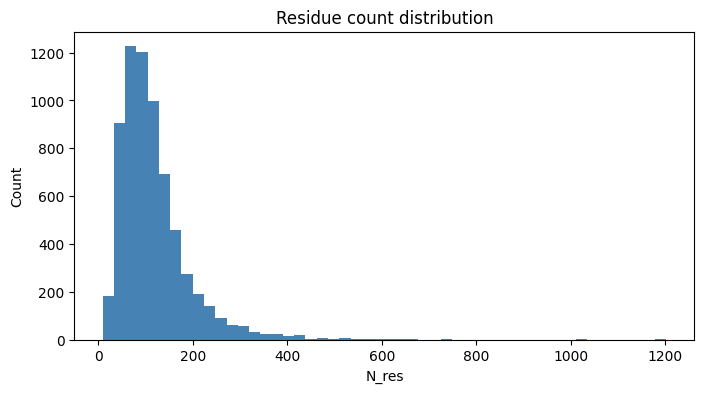

In [5]:
lengths = []
chain_counts = []
bad_records = []

for pdb_path in pdb_files:
    coords, meta = parse_ca_coords(pdb_path, chain_strategy=CHAIN_STRATEGY)
    if coords is None:
        bad_records.append((pdb_path.name, meta.get("status", "unknown")))
        continue
    lengths.append(coords.shape[0])
    chain_counts.append(meta["num_chains"])

print(f"Valid coords: {len(lengths)} / {len(pdb_files)}")
if lengths:
    print(
        "Min/median/max length:",
        int(min(lengths)),
        int(np.median(lengths)),
        int(max(lengths)),
    )
    print(f"Most common chain counts: {Counter(chain_counts).most_common(5)}")

    plt.figure(figsize=(8, 4))
    plt.hist(lengths, bins=50, color="steelblue")
    plt.title("Residue count distribution")
    plt.xlabel("N_res")
    plt.ylabel("Count")
    plt.show()
else:
    print("No valid entries found; adjust parsing settings.")


If you change `TARGET_L`, re-run the config cell and the precompute section below.


In [6]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

records = []
status_counts = Counter()

for idx, pdb_path in enumerate(pdb_files, 1):
    coords, meta = parse_ca_coords(pdb_path, chain_strategy=CHAIN_STRATEGY)
    if coords is None:
        status = meta.get("status", "parse_fail")
        status_counts[status] += 1
        records.append(
            {
                "pdb_path": str(pdb_path),
                "status": status,
                "chain_id": "",
                "n_res": "",
                "n_used": "",
                "sim_path": "",
            }
        )
        continue

    n_res = coords.shape[0]
    if n_res < MIN_RESIDUES:
        status_counts["too_short"] += 1
        records.append(
            {
                "pdb_path": str(pdb_path),
                "status": "too_short",
                "chain_id": meta.get("chain_id", ""),
                "n_res": n_res,
                "n_used": "",
                "sim_path": "",
            }
        )
        continue

    dist = pairwise_distances(coords)
    dist_padded, n_used = pad_or_trim(dist, TARGET_L, PAD_VALUE)

    if np.isnan(dist_padded).any():
        status_counts["nan"] += 1
        records.append(
            {
                "pdb_path": str(pdb_path),
                "status": "nan",
                "chain_id": meta.get("chain_id", ""),
                "n_res": n_res,
                "n_used": "",
                "sim_path": "",
            }
        )
        continue

    sim = dist_to_similarity(dist_padded, SIGMA)
    sim_path = OUTPUT_DIR / f"{pdb_path.stem}.pt"
    torch.save(sim, sim_path)

    status_counts["ok"] += 1
    records.append(
        {
            "pdb_path": str(pdb_path),
            "status": "ok",
            "chain_id": meta.get("chain_id", ""),
            "n_res": n_res,
            "n_used": n_used,
            "sim_path": str(sim_path),
        }
    )

    if idx % 500 == 0:
        print(f"Processed {idx}/{len(pdb_files)}")

with MANIFEST_PATH.open("w", newline="") as handle:
    fieldnames = ["pdb_path", "status", "chain_id", "n_res", "n_used", "sim_path"]
    writer = csv.DictWriter(handle, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(records)

print("Precompute done. Status counts:")
print(status_counts)


Processed 500/6631
Processed 1000/6631
Processed 1500/6631
Processed 2000/6631
Processed 2500/6631
Processed 3000/6631
Processed 3500/6631
Processed 4000/6631
Processed 4500/6631
Processed 5000/6631
Processed 5500/6631
Processed 6000/6631
Processed 6500/6631
Precompute done. Status counts:
Counter({'ok': 6631})


Kept 6631 samples
Kept min/median/max length: 9 100 1202


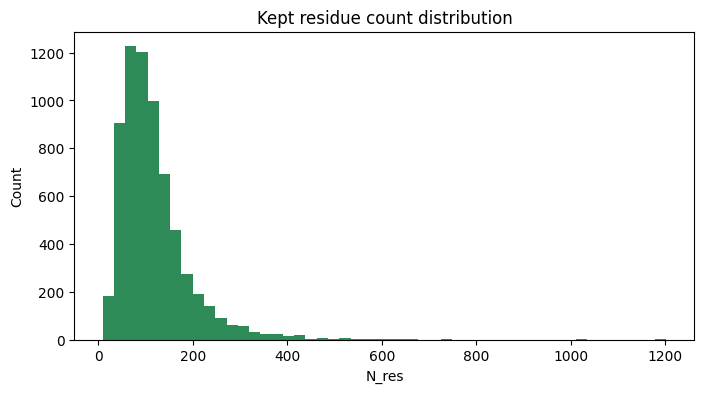

In [7]:
with MANIFEST_PATH.open("r", newline="") as handle:
    reader = csv.DictReader(handle)
    manifest_records = list(reader)

ok_records = [r for r in manifest_records if r["status"] == "ok"]
ok_lengths = [int(r["n_res"]) for r in ok_records]

print(f"Kept {len(ok_records)} samples")
if ok_lengths:
    print(
        "Kept min/median/max length:",
        int(min(ok_lengths)),
        int(np.median(ok_lengths)),
        int(max(ok_lengths)),
    )

    plt.figure(figsize=(8, 4))
    plt.hist(ok_lengths, bins=50, color="seagreen")
    plt.title("Kept residue count distribution")
    plt.xlabel("N_res")
    plt.ylabel("Count")
    plt.show()


In [8]:
class SimilarityDataset(Dataset):
    def __init__(self, manifest_path: Path, return_mask: bool = False, add_channel: bool = False):
        self.manifest_path = manifest_path
        self.return_mask = return_mask
        self.add_channel = add_channel

        with manifest_path.open("r", newline="") as handle:
            reader = csv.DictReader(handle)
            self.records = [row for row in reader if row["status"] == "ok"]

        if not self.records:
            raise ValueError("No valid samples in manifest.")

    def __len__(self) -> int:
        return len(self.records)

    def _make_mask(self, n_used: int, shape: tuple[int, int] | tuple[int, int, int]) -> torch.Tensor:
        mask = torch.zeros(shape, dtype=torch.bool)
        if self.add_channel:
            mask[:, :n_used, :n_used] = True
        else:
            mask[:n_used, :n_used] = True
        return mask

    def __getitem__(self, idx: int):
        rec = self.records[idx]
        sim = torch.load(rec["sim_path"])
        if self.add_channel:
            sim = sim.unsqueeze(0)
        if self.return_mask:
            n_used = int(rec["n_used"])
            mask = self._make_mask(n_used, sim.shape)
            return sim, mask
        return sim


dataset = SimilarityDataset(MANIFEST_PATH, return_mask=True, add_channel=False)
indices = list(range(len(dataset)))
random.Random(RANDOM_SEED).shuffle(indices)
split = int(0.8 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

batch = next(iter(train_loader))
sim_batch, mask_batch = batch
print(sim_batch.shape, mask_batch.shape)


torch.Size([64, 100, 100]) torch.Size([64, 100, 100])


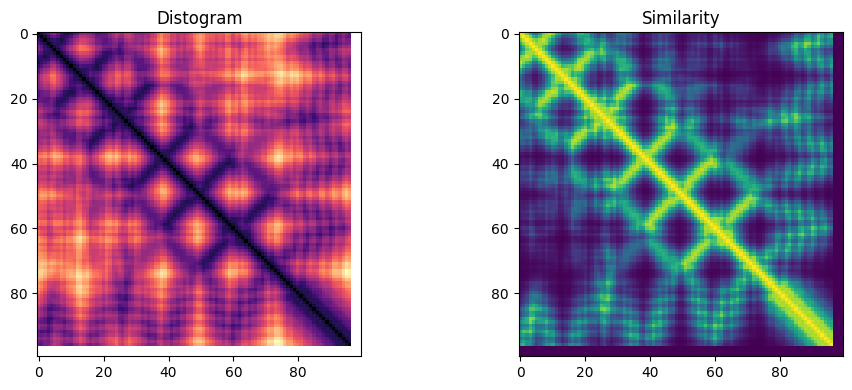

In [13]:
sample_rec = dataset.records[7]
sample_path = Path(sample_rec["pdb_path"])

coords, meta = parse_ca_coords(sample_path, chain_strategy=CHAIN_STRATEGY)
dist = pairwise_distances(coords)
dist_padded, n_used = pad_or_trim(dist, TARGET_L, PAD_VALUE)
sim = dist_to_similarity(dist_padded, SIGMA).numpy()

dist_vis = dist_padded.copy()
dist_vis[~np.isfinite(dist_vis)] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(dist_vis, cmap="magma")
axes[0].set_title("Distogram")

axes[1].imshow(sim, cmap="viridis", vmin=0.0, vmax=1.0)
axes[1].set_title("Similarity")

plt.tight_layout()
plt.show()
